***Welcome to Medical image processing in Python***<br/>

Presented by: Reza Saadatyar (2024-2025) <br/>
E-mail: Reza.Saadatyar@outlook.com 

**Outline:**<br/>
**1️⃣ Importing the dataset**<br/>
**2️⃣ Convert the images into array & masks to binary**<br/>
**3️⃣ RGB to gray**<br/>
**4️⃣ [Image Resizing](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize)**<br/>
**5️⃣ Augmentation**<br/>
**6️⃣ Mask-Based Image Cropping**<br/>

<font color='#FF000e' size="4.8" face="Arial"><b>Importing libraries</b></font>

In [1]:
import os
import pprint
import shutil
import numpy as np
from colorama import Fore
import matplotlib.pyplot as plt

from tensorflow import keras
from skimage import io, transform, color 

from Functions.filepath_extractor import FilePathExtractor

<font color=#070bee size="4.5" face="Arial"><b>1️⃣ Importing the dataset</b></font><br/>
Load the medical images and their corresponding masks into the program.

In [3]:
# ================================================ Inputs ======================================================
directory_path = "D:/Medical-Image-Processing/Data/Inputs"

# Create an instance of DirectoryReader with the directory path and file format
obj_inputs = FilePathExtractor(directory_path, format_type="tif")
img_filesname = obj_inputs.filesname            # List of filesname in the directory with the specified extension
folders = obj_inputs.folders_path               # List of folders path where the files are located
all_files_path = obj_inputs.all_files_path      # List of full files path for the files
subfoldersname = obj_inputs.subfoldersname      # List of subfolders name within the directory

pprint.pprint({
               "File Names": img_filesname,
               "Folder Paths": folders,
               "Subfolder Names": subfoldersname
              }
              )

{'File Names': ['ytma10_010704_benign1_ccd.tif',
                'ytma10_010704_benign2_ccd.tif',
                'ytma10_010704_benign3_ccd.tif',
                'ytma10_010704_malignant1_ccd.tif',
                'ytma10_010704_malignant2_ccd.tif',
                'ytma10_010704_malignant3_ccd.tif',
                'ytma12_010804_benign1_ccd.tif',
                'ytma12_010804_benign2_ccd.tif',
                'ytma12_010804_benign3_ccd.tif',
                'ytma12_010804_malignant1_ccd.tif',
                'ytma12_010804_malignant2_ccd.tif',
                'ytma12_010804_malignant3_ccd.tif',
                'ytma23_022103_benign1_ccd.tif',
                'ytma23_022103_benign2_ccd.tif',
                'ytma23_022103_benign3_ccd.tif',
                'ytma23_022103_malignant1_ccd.tif',
                'ytma23_022103_malignant2_ccd.tif',
                'ytma23_022103_malignant3_ccd.tif',
                'ytma49_042003_benign1_ccd.tif',
                'ytma49_042003_benign2_ccd

In [4]:
# ==================================================== Masks ===================================================
directory_path = "D:/Medical-Image-Processing/Data/Masks/"

# Create an instance of DirectoryReader with the directory path and file format
obj_masks = FilePathExtractor(directory_path, format_type="TIF")
mask_filesname = obj_masks.filesname      # List of filesname in the directory with the specified extension
folders = obj_masks.folders_path           # List of folders path where the files are located
files_path = obj_masks.all_files_path      # List of full files path for the files
subfoldersname = obj_masks.subfoldersname  # List of subfolders name within the directory

pprint.pprint({
               "File Names": mask_filesname,
               "Folder Paths": folders,
               "Subfolder Names": subfoldersname
              }
              )

{'File Names': ['ytma10_010704_benign1.TIF',
                'ytma10_010704_benign2.TIF',
                'ytma10_010704_benign3.TIF',
                'ytma10_010704_malignant1.TIF',
                'ytma10_010704_malignant2.TIF',
                'ytma10_010704_malignant3.TIF',
                'ytma12_010804_benign1.TIF',
                'ytma12_010804_benign2.TIF',
                'ytma12_010804_benign3.TIF',
                'ytma12_010804_malignant1.TIF',
                'ytma12_010804_malignant2.TIF',
                'ytma12_010804_malignant3.TIF',
                'ytma23_022103_benign1.TIF',
                'ytma23_022103_benign2.TIF',
                'ytma23_022103_benign3.TIF',
                'ytma23_022103_malignant1.TIF',
                'ytma23_022103_malignant2.TIF',
                'ytma23_022103_malignant3.TIF',
                'ytma49_042003_benign1.TIF',
                'ytma49_042003_benign2.TIF',
                'ytma49_042003_benign3.TIF',
                'ytma49_0420

In [5]:
# ============================================ Check of the Images =============================================
# Define the format type for input files (e.g., filenames ending with "_ccd.tif")
inputs_format_type = "_ccd.tif"

# Define the format type for mask files (e.g., filenames ending with ".TIF")
mask_format_type = ".TIF"

# Compare the base filenames (without extensions) of input files and mask files
# This line checks if the list of base filenames for input files matches the list of base filenames for mask files
[i.split(inputs_format_type)[0] for i in img_filesname] == [i.split(mask_format_type)[0] for i in mask_filesname]

True

<font color=#09eb14 size="4.5" face="Arial"><b> 2️⃣ Convert the images into array</b></font><br/>
Transform images and masks into a format suitable for processing.<br/>
▪ Read each image file into an array using a library like skimage.io.<br/>
▪ Convert mask images into boolean arrays (e.g., 0 for background, 1 for foreground) to represent binary segmentation.<br/>

In [15]:
class ImageProcessor:
    """
    A class for processing image data, including resizing.
    """
    def __init__(self):
        """
        Initialize the ImageProcessor class.

        **Import module:**
        - from Functions.image_processor import ImageProcessor
        
        **Example:**
        
        obj = ImageProcessor()
        1. Images into ndarray
           - data = obj.read_images(directory_path, format_type="tif")
           - print(Fore.GREEN + f"{data.shape = }")
        2. Masks into binary
           - masks = obj.masks_to_binary(directory_path, format_type="TIF")
           - print(Fore.GREEN + f"{masks.shape = }"
        3. Rgb into gray
           - img_gray = obj.rgb_to_gray(directory_path, save_path, format_type="tif", save_img_gray="off")
        4. Resize images
           - resized_images = obj.resize_images(data, img_height_resized=255, img_width_resized=255)  # Resize all
             images to 255x255
           - print(Fore.GREEN + f"Resizing images from {data.shape} to {resized_images.shape}")
        5. Augmentation
           - obj.augmentation(file_path, augmente_path, num_augmented_imag, rotation_range, format_type="tif")
        6. Crop images & masks
           - cropped_imgs, cropped_masks = obj.crop_images_using_masks(data_path, masks_path, data_format_type, 
             mask_format_type)
        """
    # ============================================ Images convert to ndarray ===================================
    def read_images(self, directory_path:str, format_type:str) -> np.ndarray:
        """
        Convert images from a specified directory into a NumPy array.

        **Args:**
        - directory_path (str): The path to the directory containing the images.
        - format_type (str): The file format of the images (e.g., 'jpg', 'png').

        **Returns:**
        - numpy.ndarray: A NumPy array containing all the images. If the images are grayscale, the array shape 
          will be (num_files, height, width). If the images are colored (e.g., RGB), the array shape will be 
          (num_files, height, width, channels).

        **Example:**
        - obj = ImageProcessor()
        - imgs = obj.read_images(directory_path, format_type="tif")

        **Raises:**
        - ValueError: If no files are found in the specified directory.
        """
        # Create an instance of FilePathExtractor to retrieve files path
        obj_path = FilePathExtractor(directory_path, format_type)
        
        # Get a list of all files path in the specified directory
        files_path = obj_path.all_files_path

        # Check if the list of files path is empty
        if not files_path: raise ValueError("No files found in the specified directory.")

        # Get the total number of image files
        num_files = len(files_path)  # Total number of image files

        # Read the first image to determine its dimensions and type (grayscale or colored)
        img = io.imread(files_path[0])  # Read the first image

        # Check if the image is grayscale or colored
        if img.ndim == 2:  # Grayscale image (2D array)
            img_height, img_width = img.shape  # Get image dimensions (height, width)
            
            # Initialize an empty NumPy array to store all grayscale images
            imgs = np.zeros((num_files, img_height, img_width),
                            dtype=np.uint8  # Pixel values are stored as unsigned 8-bit integers
                           )
        else:  # Colored image (e.g., RGB) (3D array)
            img_height, img_width, img_channels = img.shape  # Get image dimensions (height, width, channels)

            # Initialize an empty NumPy array to store all colored images
            imgs = np.zeros((num_files, img_height, img_width, img_channels),
                            dtype=np.uint8
                            )

        # Load all images into the NumPy array
        for idx, file_path in enumerate(files_path):
            imgs[idx] = io.imread(file_path)  # Read and store each image in the array

        # Return the NumPy array containing all images
        return imgs
    
    # ============================================ Masks convert to binary =====================================
    def masks_to_binary(self, directory_path:str, format_type:str="TIF") -> np.ndarray:
        """
        Convert mask images from a specified directory into a binary NumPy array.

        **Args:**
        - directory_path (str): The path to the directory containing the mask images.
        - format_type (str, optional): The file format of the mask images (default is "TIF").

        **Returns:**
        - numpy.ndarray: A binary NumPy array of shape [num_files, height, width, 1], where:
            - 0 represents background
            - 1 represents foreground (mask)

        **Example:**
        - obj = ImageProcessor()
        - masks = obj.masks_to_binary(directory_path, format_type="TIF")

        **Raises:**
            ValueError: If no files are found in the specified directory.
        """
        # Create an instance of FilePathExtractor to retrieve file paths
        obj_path = FilePathExtractor(directory_path, format_type)

        # Get a list of all files path in the specified directory
        files_path = obj_path.all_files_path

        # Check if the list of files path is empty
        if not files_path:  raise ValueError("No files found in the specified directory.")

        # Get the total number of image files
        num_files = len(files_path)  # Total number of image files

        # Read the first image to determine its dimensions
        mask = io.imread(files_path[0])  # Read the first mask image using scikit-image

        # Initialize a binary NumPy array to store all masks
        # Shape: [num_files, height, width, 1]
        masks = np.zeros((num_files, mask.shape[0], mask.shape[1], 1), dtype=np.uint8)
        
        # Load all images into the NumPy array
        for ind, file_path in enumerate(files_path):
            # Read image and convert to binary (0 and 1)
            mask = io.imread(file_path)
            mask = (mask > 0).astype(np.uint8)  # Convert to binary
            masks[ind] = np.expand_dims(mask, axis=-1)

        return masks
    # ============================================== RGB_to_Gray ===============================================   
    def rgb_to_gray(self, directory_path: str, save_path: str, format_type: str, save_img_gray: str = "off") -> np.ndarray:
        """
        Convert RGB images in the specified directory to grayscale.

        **Args:**
        - directory_path (str): Path to the directory containing image files.
        - format_type (str): File format (e.g., ".jpg", ".png") to filter images.
        - save_img_gray (str, optional): Whether to save the grayscale images. Defaults to "off".
            If set to "on", grayscale images are saved to a subfolder named 'Gray image/'.

        **Returns:**
        - np.ndarray: A NumPy array containing grayscale images with shape [num_images, height, width].

        **Raises:**
        - ValueError: If no files are found in the specified directory.

        Notes:
        - The grayscale images are saved in a subfolder named 'Gray image/' within the specified directory.
        - The function uses `skimage.color.rgb2gray` for RGB-to-grayscale conversion.
        
        **Example:**
        - obj = ImageProcessor()
        - img_gray = obj.RGB2Gray(directory_path, save_path, format_type, save_img_gray="off")
        """
        # Create an instance of FilePathExtractor to retrieve file paths
        obj_path = FilePathExtractor(directory_path, format_type=format_type)

        # Get a list of all file paths in the specified directory
        files_path = obj_path.all_files_path

        # Get corresponding filenames
        files_name = obj_path.filesname

        # Check if the list of file paths is empty
        if not files_path: raise ValueError("No files found in the specified directory.")

        # Retrieve the dimensions of the first image to initialize the grayscale array
        img_height, img_width, _ = io.imread(files_path[0]).shape

        # Initialize a NumPy array to store grayscale images
        img_gray = np.zeros((len(files_path), img_height, img_width), dtype=np.uint8)

        # Convert each image to grayscale
        for ind, val in enumerate(files_path):
            # Read the image, convert it to grayscale, scale back to [0, 255], and store it in the array
            img_gray[ind] = (color.rgb2gray(io.imread(val)) * 255).astype(np.uint8)

        # Save grayscale images if requested
        if save_img_gray.lower() == "on":
            # Create a folder named 'Gray image/' inside the specified save path, if it doesn't already exist
            os.makedirs(os.path.join(save_path, 'Gray image/'), exist_ok=True)

            # Loop through each image and its corresponding filename
            for ind, filename in enumerate(files_name):
                # Save each grayscale image to the 'Gray image/' folder using its original filename
                io.imsave(fname=os.path.join(save_path, 'Gray image/', filename), arr=img_gray[ind])

            # Print a success message to the console
            print(Fore.GREEN + "The images have been saved successfully.")

        # Return the grayscale images as a NumPy array
        return img_gray
    
    # ================================================ Resizes =================================================
    def resize_images(self, data: np.ndarray, img_height_resized: int, img_width_resized: int) -> np.ndarray:
        """
        Resizes a batch of images to the specified height and width.

        **Args:**
        - data (np.ndarray): A batch of images as a NumPy array. The shape can be:
            - [num_images, height, width] for grayscale images.
            - [num_images, height, width, channels] for colored images.
        - img_height_resized (int): Target height of the images after resizing.
        - img_width_resized (int): Target width of the images after resizing.

        **Returns:**
        - np.ndarray: A NumPy array of resized images with the same number of dimensions as the input.

        **Notes:**
        - Grayscale images are resized to shape [num_images, img_height_resized, img_width_resized].
        - Colored images are resized to shape [num_images, img_height_resized, img_width_resized, channels].
        - The `preserve_range=True` argument ensures that the pixel value range is maintained during resizing.

        **Example:**
        - obj = ImageProcessor()
        - resized_images = obj.resize_images(data, img_height_resized=255, img_width_resized=255) 
        """
        # Check if the input is grayscale (3D) or colored (4D)
        if data.ndim == 3:  # Grayscale images (no color channels)
            # Initialize an array to store resized grayscale images
            resized_imgs = np.zeros(
                (data.shape[0], img_height_resized, img_width_resized),
                dtype=np.uint8  # Use unsigned 8-bit integers for pixel values
            )

        else:  # Colored images (4D array with channels)
            img_channels = data.shape[-1]  # Get the number of color channels
            # Initialize an array to store resized colored images
            resized_imgs = np.zeros(
                (data.shape[0], img_height_resized, img_width_resized, img_channels),
                dtype=np.uint8  # Use unsigned 8-bit integers for pixel values
            )

        # Loop through each colored image in the batch
        for i in range(data.shape[0]):
            # Resize the image to the target dimensions and store it
            resized_imgs[i] = transform.resize(
                data[i], (img_height_resized, img_width_resized),
                preserve_range=True  # Preserve the range of pixel values
            )

        # Return the resized images
        return resized_imgs

    # ============================================= Augmentation ===============================================
    def augmentation(self, directory_path: str, augmente_path: str, num_augmented_imag: int, rotation_range: int,
                 format_type: str) -> None:
        """
        Applies image augmentation (rotation) to images in the specified directory and saves them.

        **Args:**
        - directory_path (str): Path to the directory containing the images.
        - augmente_path (str): Path to the directory to save augmented images.
        - num_augmented_imag (int): Number of augmented images to generate.
        - rotation_range (int): Degree range for random image rotation.
        - format_type (str): File format to filter images (e.g., ".jpg", ".png").

        **Notes:**
        - A temporary folder is created inside the input directory for processing.
        - The `ImageDataGenerator` from Keras is used for image augmentation.
        - Augmented images are saved in a subfolder named 'Rotated' within the `augmente_path`.
        
        **Example:**
        - obj = ImageProcessor()
        - obj.augmentation(file_path, augmente_path, num_augmented_imag, rotation_range, format_type="tif")
          - rotation_range = 30
          - num_augmented_imag = 3
        """
        # Create a subfolder for rotated images within the augmented images directory
        augmente_path = os.path.join(augmente_path, 'Augmented/')

        # Check if the augmented images folder exists, delete it if so
        if os.path.exists(augmente_path):
            shutil.rmtree(augmente_path)  # Delete the folder and its contents
        os.makedirs(augmente_path, exist_ok=True)  # Recreate the folder

        # Create a temporary folder inside the input directory for processing
        TEMP_DIR = os.path.join(directory_path, 'Temp/')
        if os.path.exists(TEMP_DIR):
            shutil.rmtree(TEMP_DIR)  # Delete the temporary folder if it exists
        os.makedirs(TEMP_DIR, exist_ok=True)  # Recreate the temporary folder

        # Create an instance of FilePathExtractor to retrieve file paths
        obj_path = FilePathExtractor(directory_path, format_type)

        # Get a list of all files path in the specified directory
        files_path = obj_path.all_files_path

        # Check if the list of files path is empty
        if not files_path: raise ValueError("No files found in the specified directory.")

        # Get corresponding filesname
        file_names = obj_path.filesname

        # Read the first image to determine its dimensions
        dat = io.imread(files_path[0])

        # Copy all files from the main folder to the temporary folder
        for ind, val in enumerate(files_path):
            shutil.copy(val, os.path.join(TEMP_DIR, file_names[ind]))

        # Set up the ImageDataGenerator for image augmentation
        Data_Gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=rotation_range)

        # Use flow_from_directory to process the images in the Temp folder
        img_aug = Data_Gen.flow_from_directory(
            directory_path,              # Parent directory of Temp
            classes=['Temp'],            # Specify the subfolder 'Temp' as the target
            batch_size=1,                # ?Process one image at a time
            save_to_dir=augmente_path,   # Save augmented images to the Rotated folder
            save_prefix='Aug',           # Prefix for augmented images
            target_size=(dat.shape[0], dat.shape[1]),  # Resize images to the specified dimensions
            class_mode=None              # No labels, as we're working with unclassified images
        )

        # Generate augmented images and save them
        for _ in range(num_augmented_imag):
            next(img_aug)  # Process the next image and save it

        # Delete the temporary folder and its contents after processing
        shutil.rmtree(TEMP_DIR)
    
    # ======================================= Mask-Based Image Cropping ========================================
    def mask_based_image_cropping(self, data_path: str, masks_path: str, data_format_type: str, mask_format_type: str) -> np.ndarray:
        """
        Crop images and their corresponding masks based on the mask boundaries.

        **Args:**
        - data_path (str): Path to the directory containing the images.
        - masks_path (str): Path to the directory containing the masks.
        - data_format_type (str): File format of the images (e.g., ".jpg", ".png").
        - mask_format_type (str): File format of the masks (e.g., ".png", ".tif").

        **Returns:**
        - tuple[np.ndarray, np.ndarray]: A tuple containing two NumPy arrays:
            - cropped_imgs: Array of cropped images with shape [num_images, height, width, channels].
            - cropped_masks: Array of cropped masks with shape [num_images, height, width].

        **Notes:**
        - The masks are expected to be binary (0 for background, 255 for foreground).
        - The images and masks are resized back to their original dimensions after cropping.
        
        **Example:**
        - obj = ImageProcessor()
        - cropped_imgs, cropped_masks = obj.crop_images_using_masks(data_path, masks_path, data_format_type, mask_format_type)
        """
        # Create an instance of FilePathExtractor for images and masks
        obj_data = FilePathExtractor(data_path, format_type=data_format_type)
        obj_masks = FilePathExtractor(masks_path, format_type=mask_format_type)

        # Get filenames and file paths for images and masks
        data_filesname = obj_data.filesname
        data_filespath = obj_data.all_files_path
        masks_filespath = obj_masks.all_files_path

        # Read the first image to determine its shape
        first_img_shape = io.imread(data_filespath[0]).shape

        # Initialize an array to store cropped images
        cropped_imgs = np.zeros((len(data_filesname), *first_img_shape), dtype=np.uint8)

        # Read the first mask to determine its shape
        first_mask_shape = io.imread(masks_filespath[0]).shape

        # Initialize an array to store cropped masks
        cropped_masks = np.zeros((len(masks_filespath), *first_mask_shape), dtype=bool)

        # Loop through each image and its corresponding mask
        for ind, val in enumerate(data_filespath):
            # Read the image and mask
            img = io.imread(val)
            mask = io.imread(masks_filespath[ind])

            # Find the coordinates of the mask's foreground (where mask == 255)
            y_coord, x_coord = np.where(mask == 255)

            # Calculate the bounding box for cropping
            y_min = min(y_coord)
            y_max = max(y_coord)
            x_min = min(x_coord)
            x_max = max(x_coord)

            # Crop and resize the image to the original dimensions
            cropped_imgs[ind] = transform.resize(
                img[y_min:y_max, x_min:x_max],
                first_img_shape,
                mode='constant',
                anti_aliasing=True,
                preserve_range=True
            )

            # Crop and resize the mask to the original dimensions
            cropped_masks[ind] = transform.resize(
                mask[y_min:y_max, x_min:x_max],
                first_mask_shape,
                mode='constant',
                anti_aliasing=True,
                preserve_range=True
            )

        # Return the cropped images and masks
        return cropped_imgs, cropped_masks


In [16]:
# ================================================ Inputs ======================================================
# Define the directory path where the input images are stored
directory_path = "D:/Medical-Image-Processing/Data/Inputs"

# Create an instance of the `ImageProcessor` class
obj = ImageProcessor()

# Use the `imgs_to_ndarray` method of the `ImageProcessor` object to load images from the directory
# The images are expected to be in "tif" format, and they are converted into a NumPy array
inputs = obj.read_images(directory_path, format_type="tif")

# Print the shape of the resulting NumPy array
# The `inputs.shape` attribute gives the dimensions of the array (e.g., number of images, height, width, channels)
print(Fore.GREEN + f"{inputs.shape = }")

inputs.shape = (58, 768, 896, 3)


<font color=#09eb14 size="4.5" face="Arial"><b> 2️⃣ Masks to binary</b></font>

In [17]:
# ==================================================== Masks ===================================================
# Define the directory path where the mask images are stored
directory_path = "D:/Medical-Image-Processing/Data/Masks/"

# Use the `imgs_to_ndarray` method of the `ImageProcessor` object to load mask images from the directory
# The masks are expected to be in "TIF" format, and they are converted into a NumPy array
masks = obj.masks_to_binary(directory_path, format_type="TIF")

# Print the shape of the resulting NumPy array
# The `masks.shape` attribute gives the dimensions of the array (e.g., number of masks, height, width)
print(Fore.GREEN + f"{masks.shape = }")

masks.shape = (58, 768, 896, 1)


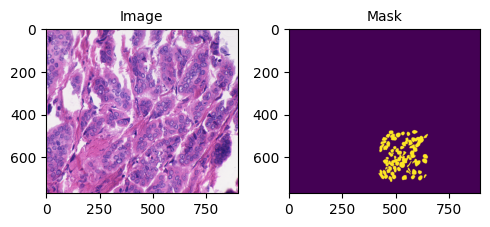

In [12]:
ind = 5 # Set the index of the image and mask to display
plt.figure(figsize=(5, 3))
plt.subplot(121); plt.imshow(inputs[ind]); plt.title('Image', fontsize=10)
plt.subplot(122); plt.imshow(masks[ind]); plt.title('Mask', fontsize=10) 
plt.tight_layout() # Adjust the layout to prevent overlap between subplots

<font color=#dd7f05 size="4.5" face="Arial"><b>3️⃣ RGB to Gray</b></font><br/>
Simplify the images by reducing color channels.<br/>
▪ Convert RGB images to grayscale using a function like skimage.color.rgb2gray.<br/>
▪ Ensure masks remain unchanged as they are typically already binary.<br/>

In [18]:
# Define the directory path where the input images are stored
directory_path = "D:/Medical-Image-Processing/Data/Inputs/"

# Define the directory path where the processed images will be saved
save_path = 'D:/Medical-Image-Processing/Data/'

# Use the `rgb_to_gray` method of the `ImageProcessor` object to convert RGB images to grayscale
# The `save_img_gray="on"` argument indicates that the grayscale images should be saved to the specified `save_path`
img_gray = obj.rgb_to_gray(directory_path, save_path, format_type="tif", save_img_gray="off")

<font color=#ec0995 size="4.5" face="Arial"><b>4️⃣ Image Resizing</b></font><br/>
Standardize image dimensions for consistent processing.<br/>
▪ Use skimage.transform.resize to adjust all images and masks to a uniform size (e.g., 256x256 pixels).<br/>
▪ Preserve the aspect ratio and data integrity during resizing.<br/>
**`Standardizing Image Dimensions:`** Machine learning models, like CNNs, need input data with fixed dimensions. For instance, if a model requires images of size 224x224x3, all input images must be resized to that shape.<br/>
**`Reducing Computational Load:`** Resizing images to smaller dimensions lowers computational costs, particularly with large datasets, and aids in faster training or inference for deep learning models.

In [19]:
# Call the `resize_images` method to resize the images to the target dimensions (255x255)
# The `inputs` array contains the original images, and the method resizes them to the specified height and width
resized_images = obj.resize_images(inputs, img_height_resized=255, img_width_resized=255)  # Resize all images to 255x255

# Print the original and resized image shapes
# The `inputs.shape` gives the dimensions of the original images (e.g., number of images, height, width, channels)
# The `resized_images.shape` gives the dimensions of the resized images (e.g., number of images, 255, 255, channels)
print(Fore.GREEN + f"Resizing images from {inputs.shape} to {resized_images.shape}")

Resizing images from (58, 768, 896, 3) to (58, 255, 255, 3)


<font color=#06defa size="4.5" face="Arial"><b>5️⃣ Augmentation</b></font><br/>
**Purpose:**<br/>
- `Increase Dataset Size:` Augmentation creates new training samples from existing ones, effectively increasing the dataset size.<br/>
- `Improve Model Robustness:` Introducing variations such as rotations, flips, and zooms helps the model adapt more effectively to real-world scenarios.<br/>
- `Prevent Overfitting:` Augmentation enhances variability, minimizing the likelihood of the model overfitting to the training data.<br/>

**Augmentation Techniques:**<br/>
- `Rotation:` Rotating images by a specified degree range (e.g., rotation_range=30).<br/>
- `Flip:` Flipping images horizontally or vertically.<br/>
- `Zoom:` Zooming in or out of images.<br/>
- `Shift:` Translating images horizontally or vertically.<br/>
- `Brightness/Contrast Adjustment:` Changing the brightness or contrast of images.<br/>
- `Noise Addition:` Adding random noise to images.<br/>

In [20]:
# Define the range of rotation for image augmentation (e.g., 30 degrees)
rotation_range = 30

# Define the number of augmented images to generate for each original image
num_augmented_imag = 3

# Path to the folder containing the original images
file_path = 'D:/Medical-Image-Processing/Data/Inputs/'

# Path where augmented images will be saved
augmente_path = 'D:/Medical-Image-Processing/Data/'

# Call the `augmentation` method to perform image augmentation
obj.augmentation(file_path, augmente_path, num_augmented_imag, rotation_range, format_type="tif")

Found 58 images belonging to 1 classes.


<font color=#ecde11 size="4.5" face="Arial"><b>6️⃣ Mask-Based Image Cropping</b></font><br/>
Focus on regions of interest by removing irrelevant areas.<br/>
▪ Use the boolean mask to identify the foreground region in each image.<br/>
▪ Calculate the bounding box around the masked area.<br/>
▪ Crop both the image and mask to the bounding box dimensions.<br/>
▪ Visualize the original and cropped images/masks for validation<br/>

In [21]:
# Define the format type for the input data files (e.g., filenames ending with "_ccd.tif")
data_format_type = '_ccd.tif'

# Define the format type for the mask files (e.g., filenames ending with ".TIF")
mask_format_type = '.TIF'

# Path to the folder containing the input images
data_path = "D:/Medical-Image-Processing/Data/Inputs/"

# Path to the folder containing the mask images
masks_path = "D:/Medical-Image-Processing/Data/Masks/"

# Call the `mask_based_image_cropping` method to crop images and masks based on the mask boundaries
# The method returns two outputs:
# - `cropped_imgs`: Cropped versions of the input images.
# - `cropped_masks`: Cropped versions of the mask images.
cropped_imgs, cropped_masks = obj.mask_based_image_cropping(data_path, masks_path, data_format_type, mask_format_type)
cropped_imgs.shape, cropped_masks.shape

((58, 768, 896, 3), (58, 768, 896))

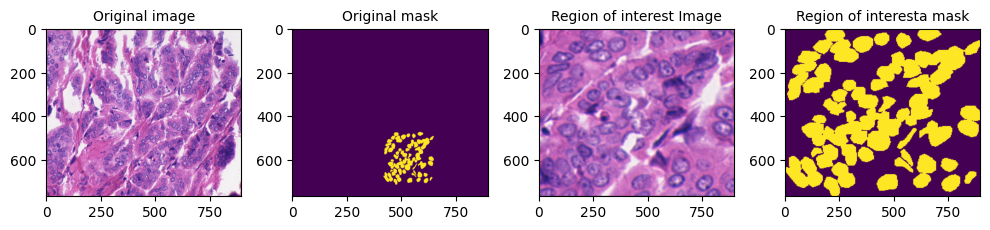

In [24]:
ind = 5 # Set the index of the image and mask to display
plt.figure(figsize=(10, 5))
plt.subplot(141); plt.imshow(inputs[ind]); plt.title('Original image', fontsize=10)
plt.subplot(142); plt.imshow(masks[ind]); plt.title('Original mask', fontsize=10)
plt.subplot(143); plt.imshow(cropped_imgs[ind]); plt.title('Region of interest Image', fontsize=10)
plt.subplot(144); plt.imshow(cropped_masks[ind]); plt.title('Region of interesta mask', fontsize=10) 
plt.tight_layout() # Adjust the layout to prevent overlap between subplots